# Construct a custom Environment for Pair Trading

Some examples on the market
* [custom env example](https://colab.research.google.com/github/araffin/rl-tutorial-jnrr19/blob/sb3/5_custom_gym_env.ipynb#scrollTo=RqxatIwPOXe_)
* [StockTradingEnv by Adam King](https://github.com/notadamking/Stock-Trading-Environment)
* [FinRL](https://github.com/AI4Finance-Foundation/FinRL)

Target is to construct a custom Env for pair trading

This env allows the learner to hold a position as a percentage



In [1]:
import warnings
warnings.filterwarnings('ignore')

import os, csv, math, pickle, shutil
import numpy as np
import pandas as pd
import gymnasium as gym
import statsmodels.api as sm
import matplotlib.pyplot as plt

from gymnasium import spaces
from datetime import date
from envs.env_gridsearch import kellycriterion
from sklearn.model_selection import train_test_split
from stable_baselines3.common.vec_env import DummyVecEnv
from utils.read2df import read2df
from utils.rlmetrics import get_return, get_metrics
from utils.clearlogs import clear_logs

# Find parameters in `params.py`
from params import *
from envs.env_rl_freeop import PairTradingEnv

from stable_baselines3 import PPO, A2C, DQN
import quantstats as qs

folder_path = f"result/rl-freeop-thres"
os.makedirs(folder_path, exist_ok=True)

Load data from `preliminaries.ipynb`

In [2]:
with open('result/cointncorr.pickle', 'rb') as pk:
    data = pickle.load(pk)

dfs = read2df(symbols=data[0], freqs={data[1]: freqs[data[1]]})

df0 = dfs[0][dfs[0]['tic']==data[0][0]].reset_index(drop=True)
df1 = dfs[0][dfs[0]['tic']==data[0][1]].reset_index(drop=True)

# Because we want to calculate profit based on BTC. Hence the price need to be changed.
df0 = df0[['time', 'close', 'volume', 'tic', 'itvl', 'datetime']]
df0['close'] = df0['close'].apply(lambda x: 1/x)

df1 = df1[['time', 'close', 'volume', 'tic', 'itvl', 'datetime']]
df1['close'] = df1['close'].apply(lambda x: 1/x)

Set data before `trade_data` as training data, after `trade_data` is trade_data

In [3]:
train0 = df0[df0['datetime'] < trade_date]
train1 = df1[df1['datetime'] < trade_date]

test0 = df0[df0['datetime'] >= trade_date]
test1 = df1[df1['datetime'] >= trade_date]

print(f"The length of our training data: {len(train0)}")

The length of our training data: 1331282


## Check with baselin3 `env_checker`

Check if the env meets the requirements of `stable_baseline3`

In [4]:
from stable_baselines3.common.env_checker import check_env
# > UserWarning: The action space is not based off a numpy array. Typically this means it's either a Dict or Tuple space. This type of action space is currently not supported by Stable Baselines 3. You should try to flatten the action using a wrapper.
# Baseline 3 does not support Dict/Tuple action spaces....only Box Discrete MultiDiscrete MultiBinary
# Is there another way to achieve the same functionality?

env = PairTradingEnv(train0, train1)
check_env(env)

## Do an experiment run with randomly generated actions

In [5]:
env = PairTradingEnv(train0, train1, tc=0.002, verbose=1, model=f"{folder_path}/networth_experiment.csv")
obs, _ = env.reset()

print(f"observation_space: {env.observation_space}")
print(f"action_space: {env.action_space}")
print(f"action_space.sample: {env.action_space.sample()}")

n_steps = 20

for step in range(n_steps):
    obs, reward, terminated, truncated, info = env.step(action=env.action_space.sample())
    done = terminated or truncated
    env.render()
    if done:
        break

observation_space: Dict('position': Box(-1.0, 1.0, (1,), float64), 'threshold': MultiBinary(5), 'zscore': Box(-inf, inf, (1,), float64))
action_space: Discrete(3)
action_space.sample: 1
networth 1.0, action 1, zscore -0.7498675219653336, pos 0, holding0 0.0, holding1 0.0
networth 1.0, action 1, zscore -0.7516868911149867, pos 0, holding0 0.0, holding1 0.0
networth 1.009996830473975, action 0, zscore -0.7514654852045904, pos -1.0, holding0 -20.634, holding1 18.493000000000002
networth 0.9884861781525639, action 0, zscore -0.7512441469138676, pos 1.0, holding0 20.634, holding1 -18.493000000000002
networth 0.9884861781525639, action 2, zscore -0.7510228761947806, pos 1.0, holding0 20.634, holding1 -18.493000000000002
networth 0.9984830086265388, action 0, zscore -0.7508016729993505, pos 0, holding0 0.0, holding1 0.0
networth 1.0084798391005139, action 0, zscore -0.7503491197992053, pos -1.0, holding0 -20.634, holding1 18.493000000000002
networth 1.0084798391005139, action 1, zscore -0.749

## Models from stable_baselines3

Delete existing tensorboard logs

In [6]:
log_path = f"logs/freeop_thres/"
clear_logs(log_path)

Deleted: logs/freeop_thres/A2C_1
Deleted: logs/freeop_thres/DQN_1
Deleted: logs/freeop_thres/PPO_1


Train with training data

In [7]:
'''PPO'''

env = PairTradingEnv(train0, train1, tc=0.00, model=f"{folder_path}/networth_ppo.csv")

model_ppo = PPO("MultiInputPolicy", env, verbose=0, tensorboard_log=log_path)
model_ppo.learn(total_timesteps=25000)
model_ppo.save(f"{folder_path}/ppo_pairtrading")

In [8]:
'''A2C'''

env = PairTradingEnv(train0, train1, tc=0.00, model=f"{folder_path}/networth_a2c.csv")

model_a2c = A2C("MultiInputPolicy", env, verbose=0, tensorboard_log=log_path)
model_a2c.learn(total_timesteps=25000)
model_a2c.save(f"{folder_path}/a2c_pairtrading")

In [9]:
'''DQN'''

env = PairTradingEnv(train0, train1, tc=0.00, model=f"{folder_path}/networth_dqn.csv")

model_dqn = DQN("MultiInputPolicy", env, verbose=0, tensorboard_log=log_path)
model_dqn.learn(total_timesteps=25000)
model_dqn.save(f"{folder_path}/dqn_pairtrading")

## Use the model on Test data

In [10]:
# del model_ppo, model_a2c, model_dqn

model_ppo = PPO.load(f"{folder_path}/ppo_pairtrading.zip")
model_a2c = A2C.load(f"{folder_path}/a2c_pairtrading.zip")
model_dqn = DQN.load(f"{folder_path}/dqn_pairtrading.zip")

In [11]:
try:
    os.remove(f"{folder_path}/networth_ppo.csv")
    print("existing networth_ppo.csv removed")
except OSError:
    print("currently no ppo results")

env = PairTradingEnv(test0, test1, tc=0, model=f"{folder_path}/networth_ppo.csv")
obs, _ = env.reset()

while True:
    action, _states = model_ppo.predict(obs)
    observation, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated
    env.render()
    if terminated:
        print("Test Finished!")
        break
    elif truncated:
        print("bankrupted!")
        break

existing networth_ppo.csv removed
Test Finished!


In [12]:
try:
    os.remove(f"{folder_path}/networth_a2c.csv")
    print("existing networth_a2c.csv removed")
except OSError:
    print("currently no a2c results")

env = PairTradingEnv(test0, test1, tc=0, model=f"{folder_path}/networth_a2c.csv")
obs, _ = env.reset()

while True:
    action, _states = model_a2c.predict(obs)
    observation, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated
    env.render()
    if terminated:
        print("Test Finished!")
        break
    elif truncated:
        print("bankrupted!")
        break

existing networth_a2c.csv removed
Test Finished!


In [13]:
try:
    os.remove(f"{folder_path}/networth_dqn.csv")
    print("existing networth_dqn.csv removed")
except OSError:
    print("currently no dqn results")

env = PairTradingEnv(test0, test1, tc=0, model=f"{folder_path}/networth_dqn.csv")
obs, _ = env.reset()

while True:
    action, _states = model_dqn.predict(obs)
    observation, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated
    env.render()
    if terminated:
        print("Test Finished!")
        break
    elif truncated:
        print("bankrupted!")
        break

existing networth_dqn.csv removed
Test Finished!


### Analyze with Quanstats

In [14]:
os.remove(f"{folder_path}/networth_experiment.csv") if os.path.exists(f"{folder_path}/networth_experiment.csv") else None

csv_files = [file for file in os.listdir(folder_path) if file.endswith('.csv')]

best_res, best_model = None, None
for file_name in csv_files:
    file_path = os.path.join(folder_path, file_name)
    
    with open(file_path, 'r') as csv_file:
        csv_reader = csv.reader(csv_file)
        
        # Loop through the lines in the CSV file
        last_line = None
        for row in csv_reader:
            last_line = row  # Update last_line with the current row
    
    if best_res is None or float(best_res) < float(last_line[1]):
        best_res = last_line[1]
        best_model = file_name

    print(f"The ending capital of {file_name} is {last_line[0:2]}")

print(f"The best model is {best_model}")

The ending capital of networth_a2c.csv is ['2023-11-30 23:59:59.999000', '0.9809339308908179']
The ending capital of networth_dqn.csv is ['2023-11-30 23:59:59.999000', '0.9924732669517446']
The ending capital of networth_ppo.csv is ['2023-11-30 23:59:59.999000', '0.9763736848566457']
The best model is networth_dqn.csv


In [15]:
best_return = get_return(f'{folder_path}/{best_model}')
get_metrics(best_return)

print(best_return.head(20))

Compound annual growth rate: -1%
Total orders count: 479875
Total long action: 231123
Total short action: 230828
Won orders count: 231123
Lost orders count: 230828
Win/Loss order ratio: 1.0012780078673298
Avg order pnl: 1.5684778428247672e-08
Avg order pnl won: 1.9960915746219084e-05
Avg order pnl lost: -2.0143312954423125e-05
Avg long order pnl: -0.00021415462369893143
Avg short order pnl: 0.00042811687430903536
                         values  action    zscore  position  pnl  returns
datetime                                                                 
2023-01-01 16:43:59.999     1.0       1  1.839629       0.0  0.0      0.0
2023-01-01 16:44:59.999     1.0       1  1.084361       0.0  0.0      0.0
2023-01-01 16:45:59.999     1.0       1  1.082180       0.0  0.0      0.0
2023-01-01 16:46:59.999     1.0       1  1.296358       0.0  0.0      0.0
2023-01-01 16:47:59.999     1.0       1  0.578434       0.0  0.0      0.0
2023-01-01 16:48:59.999     1.0       1  0.620198       0.0  0.0 

In [ ]:
fig, ax = plt.subplots()

ax.set_title("Profit and Loss")
ax.plot(best_return['pnl'])

plt.show()

                           Strategy
-------------------------  ----------
Start Period               2023-01-01
End Period                 2023-11-30
Risk-Free Rate             0.0%
Time in Market             97.0%

Cumulative Return          -0.75%
CAGR﹪                     -0.57%

Sharpe                     0.02
Prob. Sharpe Ratio         76.72%
Smart Sharpe               0.02
Sortino                    0.02
Smart Sortino              0.02
Sortino/√2                 0.02
Smart Sortino/√2           0.02
Omega                      1.01

Max Drawdown               -4.96%
Longest DD Days            326
Volatility (ann.)          3.36%
Calmar                     -0.12
Skew                       -1.48
Kurtosis                   56.14

Expected Daily %           -0.0%
Expected Monthly %         -0.07%
Expected Yearly %          -0.75%
Kelly Criterion            0.65%
Risk of Ruin               0.0%
Daily Value-at-Risk        -0.35%
Expected Shortfall (cVaR)  -0.35%

Max Consecutive Wins    

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2023-01-09,2023-07-12,2023-11-30,326,-4.957097,-4.878432
2,2023-01-03,2023-01-04,2023-01-09,6,-2.468819,-2.458557
3,2023-01-03,2023-01-03,2023-01-03,1,-2.344319,-2.339248
4,2023-01-01,2023-01-01,2023-01-03,2,-2.249681,-2.245270
5,2023-01-03,2023-01-03,2023-01-03,1,-1.206269,-1.204483


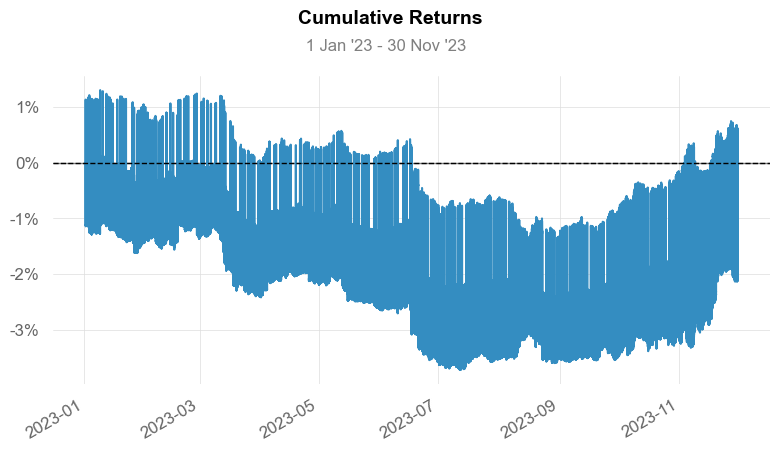

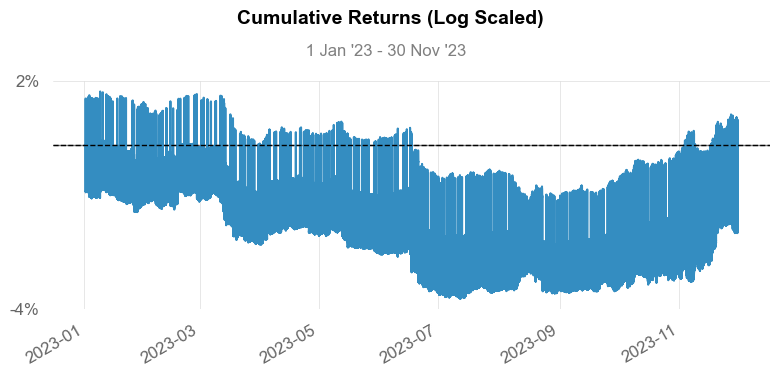

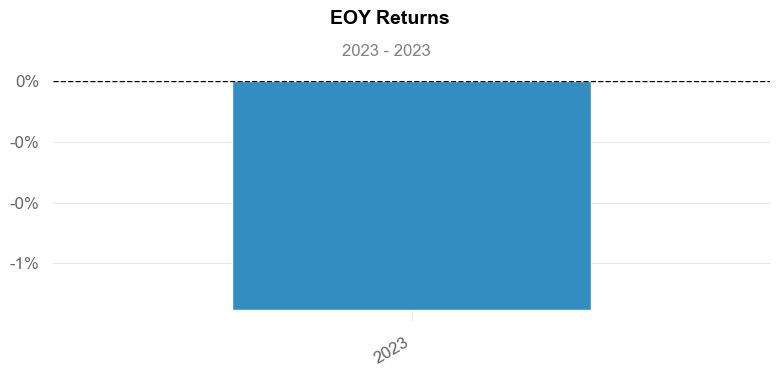

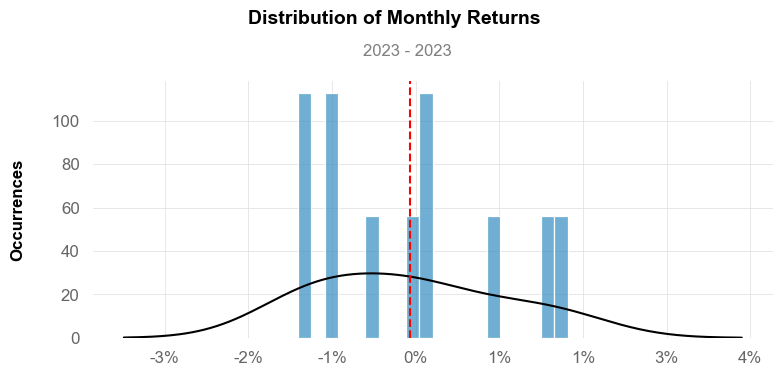

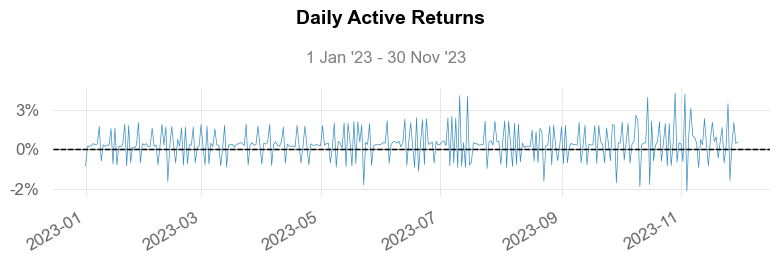

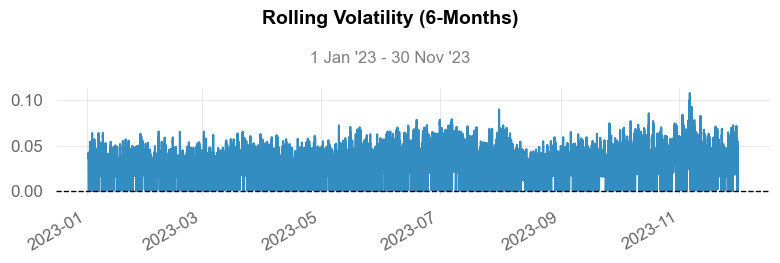

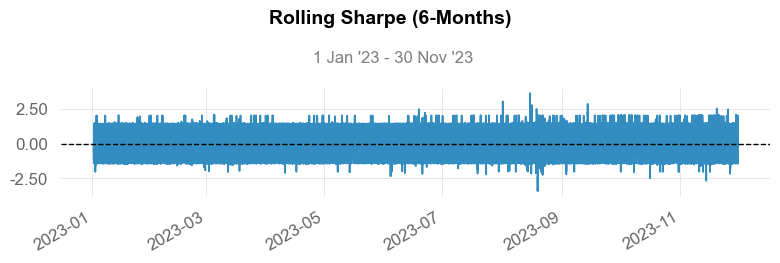

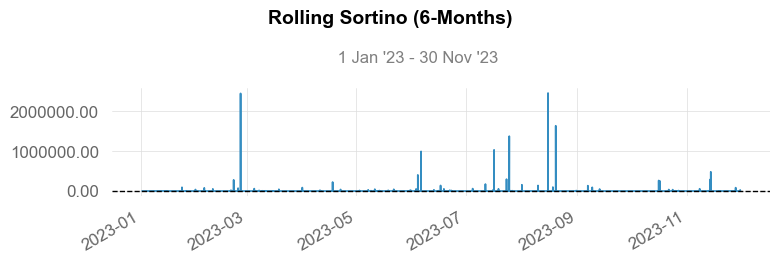

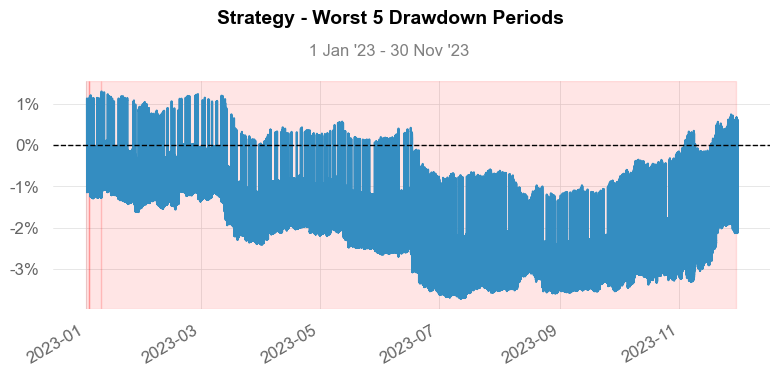

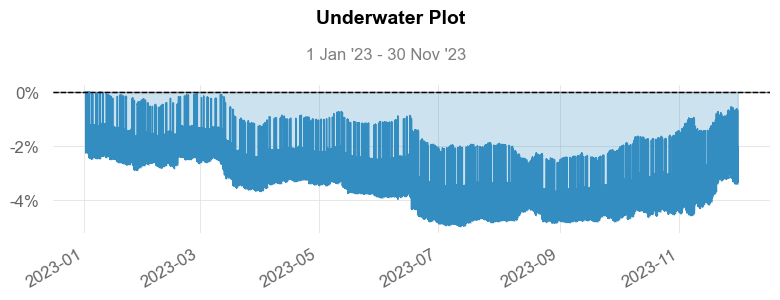

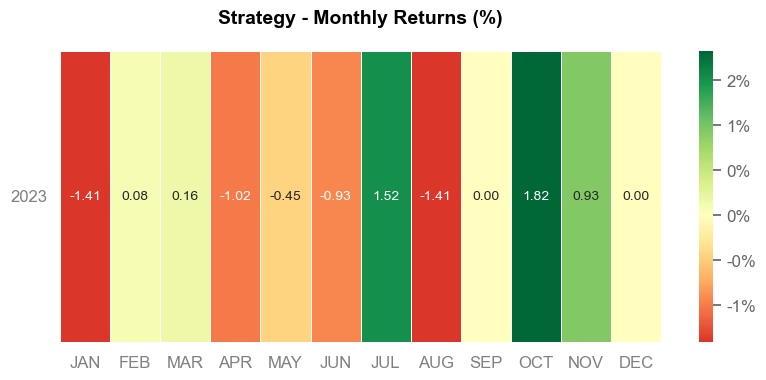

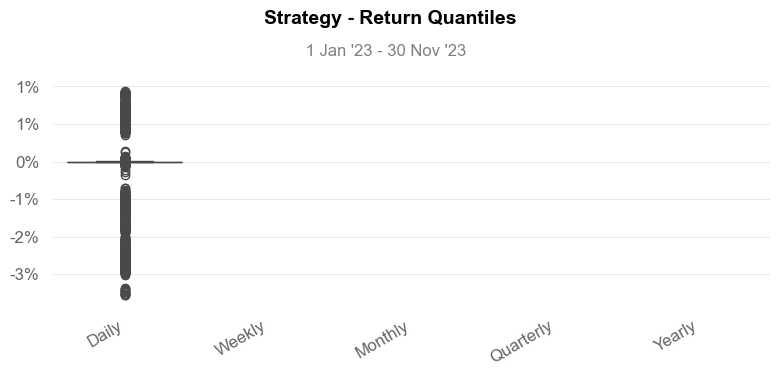

In [16]:
# best_return_daily = best_return['returns'].resample('1d').apply(lambda x: np.prod(1 + x) - 1)
qs.reports.full(best_return['returns'])